In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import GPy
import cvxpy

plt.style.use('ggplot')

In [2]:
def gauss_gp(y, plot = False, extra_len = 1):
    """
    y: np n x 1 array of input data
    """   
    x = np.atleast_2d(np.linspace(0, y.shape[0] - 1, y.shape[0])).T
    
    # squared gaussian kernel
    kernel  = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

    # initialize gaussian process
    gp = GPy.models.GPRegression(x,y,kernel)
    
    # optimize gp
    gp.optimize()
  
    # point to predict at
    point = (x[-1] + 1).reshape(1, -1)
    
    # predict
    pred, sigma = gp.predict(point)
    
    return_frac = pred / y[-1] - 1
    
    # plotting
    if plot:
        plot_gp(x, y, gp, (point[0,0], pred[0,0]), extra_len)
    
    # return sharpe
    return return_frac[0,0], sigma

In [3]:
def plot_gp(x, y, gp, point, extra_len = 1):
    """
    x: numpy array of the domain of the gp
    y: original data
    gp: a 1d GPRegression object
    point: tuple of predicted point
    """
    domain = np.linspace(x[0], point[0] + extra_len, 200)[:, np.newaxis]
    pred, sigma = gp.predict(domain)
    plt.figure(figsize = (14,10))
    plt.plot(domain, pred, label = 'Prediction Mean', color = 'k')
    plt.scatter(x, y, label = 'Actual Values', color = 'r', marker = 'o')
    
    plt.fill_between(domain[:,0], (pred - sigma)[:,0], (pred + sigma)[:,0], alpha=.5, label = '+/- sigma')
    
    plt.xlim(0,domain[-1])
    
    plt.plot(point[0], point[1], label = 'Predicted Price', marker = '*', c = 'black', markersize = 20.)
    
    plt.legend()
    
    

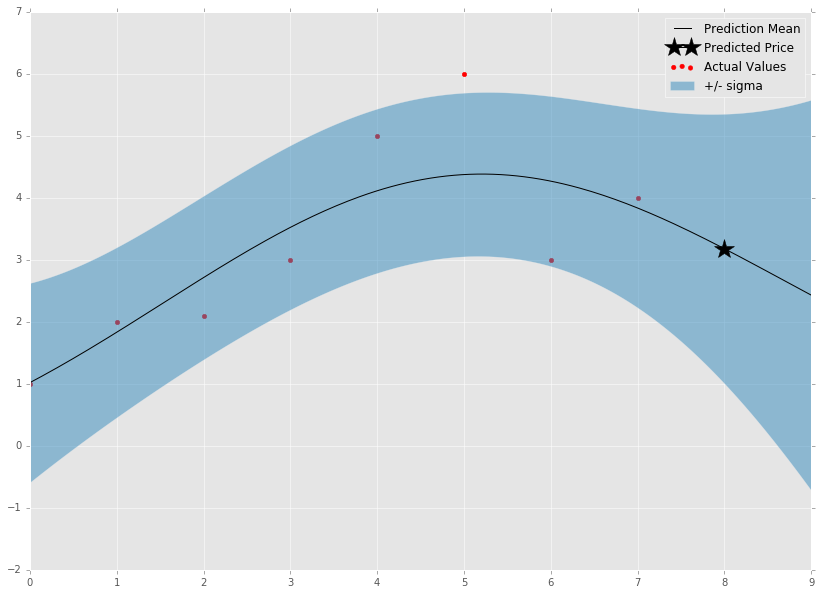

In [215]:
a = np.array([[1, 2, 2.1, 3, 5, 6,3 ,4]]).T
R, cov = gauss_gp(a, True)

In [4]:
def cov_return_sigma(X, sharpe_func):
    """
    X: n x k numpy array of stocks
    sharpe_func: function that takes an n x 1 array of input data and 
                 returns a tuple of return rate and std. deviation of 
                 that return rate
    """
    
    cov = np.cov(X)
    
    return_sigma = np.array([sharpe_func(X[i][:, np.newaxis]) for i in range(X.shape[0])])
    
    returns = return_sigma[:,0]
    sigma = return_sigma[:,1]
    
    return cov, returns, sigma
    

In [5]:
def read_stocks(dir_name, random = False, num_rand = None):
    """
    dir_name: string directory name
    
    returns: stocks as rows all concatenated to min. length
    
    Assumes stocks are csv's
    """
    stock_files = glob.glob(dir_name + '/*.csv')
    
    if random:
        ind = np.random.randint(0, len(stock_files), size = num_rand)
        stock_files = list(np.array(stock_files)[ind])
    
    labels = []
    
    X = []
    min_len = 100000
    
    for stock in stock_files:
        x = pd.read_csv(stock)['Adj Close'].as_matrix().astype(np.float64)
        if x.shape[0] >= 100:
            if x.shape[0] < min_len:
                min_len = x.shape[0]
            X.append(x)
            labels.append(stock[len(dir_name) + 1:][0:-4])
        
    for i in range(len(X)):
        X[i] = X[i][-min_len:]
        
    X = np.array(X)
    
    # lables
    return labels, X[:,0:-1], X[:,-1][:,np.newaxis]

In [6]:
def optimize_port(R, sigma, theta):
    """
    cor: Nxk correlation matrix of stocks
    returns: Nx1 return fraction matrix
    sigma: Nx1 expected standard deviation on returns
    """
    
    w = cvxpy.Variable(R.shape[0])
    
    objective = cvxpy.Minimize(-theta * R.T @ w + (1 - theta) * cvxpy.quad_form(w, sigma))
    
    ones = np.ones(R.shape[0])
    
    constraints = [w >= 0, sum(w) == 1]
    
    problem = cvxpy.Problem(objective, constraints)
    
    result = problem.solve()
    
    return (w.value)
    
    

In [102]:
labels, X, y = read_stocks('/home/nate/Courses/bigdata/bigdata_hw/final_project/DAILY', random = True, num_rand=50)

X2 = np.vstack((X, np.ones(X.shape[1])))

y2 = np.vstack((y, 1.))

labels.append('No Investment')

cov, returns, sigma = cov_return_sigma(X2, gauss_gp) 

cov += 10 * np.diag(sigma)
    
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

is_pos_def(cov)

True

In [17]:
weights = optimize_port(returns, cov, .3)

In [81]:
def theta_search(returns, cov, precision, verbose = False, max_iters = 100):
    theta = 0.
    error = 1.
    iters = 0
    while error > precision and iters < max_iters:
        if theta > 1.:
            theta = 1.
            weights = optimize_port(returns, cov, theta)
            break
        elif theta < 0:
            theta = 0.
            weights = optimize_port(returns, cov, theta)
            break
        else:
            weights = optimize_port(returns, cov, theta)
            
        if abs(weights[-1][0,0]) <= 1e-10:
            theta -= error
        else:
            theta += error
        error /= 2
        
        iters += 1
    print("iterations: {}, final theta: {}, error: {}".format(iters, theta, error))
    return theta, weights

opt_theta, opt_weights = theta_search(returns, cov, .00001, True)

iterations: 17, final theta: 0.9607391357421875, error: 7.62939453125e-06


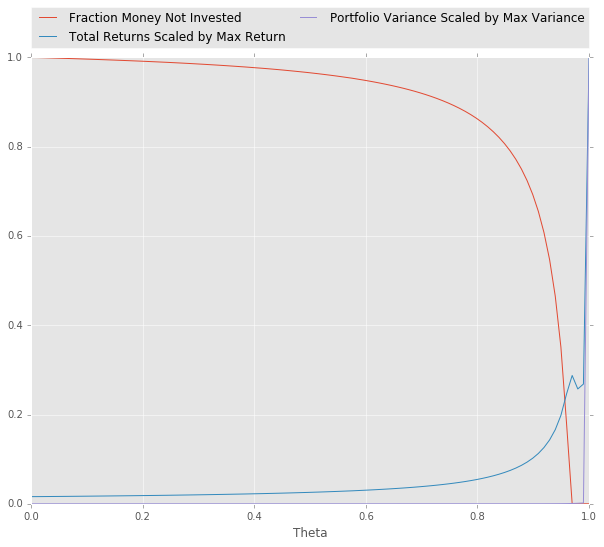

In [10]:
l = np.array(labels)[:,np.newaxis]

no_invest = []
returns_l = []
port_cov = []

thetas = np.linspace(0, 1, 100)

for theta in thetas:

    opt = optimize_port(returns, cov, theta)

    returns_l.append(return_frac(opt, X2, y2))
    no_invest.append(opt[-1][0,0])
    port_cov.append((opt.T @ cov @ opt)[0,0])
    
plt.figure(figsize = (10,8))
plt.plot(thetas, no_invest, label = "Fraction Money Not Invested")
plt.plot(thetas, np.array(returns_l) / max(returns_l), label = "Total Returns Scaled by Max Return")

plt.plot(thetas, np.array(port_cov) / max(port_cov), label = "Portfolio Variance Scaled by Max Variance")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

plt.title('')
plt.xlabel("Theta")

In [ ]:
opt = optimize_port(returns, cov, 0.5)

choices = l[np.where(opt>.001)]

weights = opt[opt>.001]

weights /= np.sum(weights)

print(weights, choices)

weights.shape

return_frac(opt, X2, y2)

In [9]:
def return_frac(w, X, y):
    """
    w: weights of stocks
    X: original data
    y: back_test data
    """
    returns = (y / X[:,-1])
    return (w.T @ returns)[0,0]

In [ ]:
def find_theta(X, y, returns, cov, days, verbose = False):
    """
    
    """
    bestVal = -10000
    bestTheta = 0
    
    if verbose:
        print('Beginning Theta Optimization')

    for theta in np.linspace(0, 1, 10):
        if verbose:
            print('{:04.2f}% done'.format(float(theta * 100)))
        
        opt = optimize_port(returns, cov, theta)
        
        
        return_list = trade_period(X, days, theta)

        temp = total_return(return_list)
        if temp > bestVal:
            bestVal = temp
            bestTheta = theta    
    return bestVal, bestTheta

In [394]:
bestValm, bestTheta= find_theta(X[:,0:10],y[:,0:10],returns, cov, days = 1, verbose= True)
print(bestValm, bestTheta)

Beginning Theta Optimization
0.00% done
11.11% done
22.22% done
33.33% done
44.44% done
55.56% done
66.67% done
77.78% done
88.89% done
100.00% done
1.00357686359 0.0


In [83]:
def full_test(dir_name, num_stocks, num_tests, days, verbose = False):
    """
    dir_name: directory to test on
    num_stocks: stocks per test
    num_tests: number of test iterations
    theta: pre chosen theta
    days: number of days per simulation
    verbose: print as progressing?
    """
    returns_list = []

    for i in range(num_tests):
        if verbose:
            print('{}% complete'.format(i * 100./num_tests))
        
        labels, X, y = read_stocks(dir_name, random = True, num_rand=num_stocks)
        
        if verbose:
            print('Reading complete')
  
        
        if verbose:
            print('Simulating {} trading days'.format(days))
        
        simulated_returns = trade_period(X, days, verbose)
        returns_list.append(total_return(simulated_returns))
        
        if verbose:
            print('Iteration complete\n')
            
    if verbose:
        print('Done')
        
    return returns_list

In [85]:
returns_list = full_test('/home/nate/Courses/bigdata/bigdata_hw/final_project/DAILY', num_stocks = 50, num_tests = 10, days = 10, verbose=True)   

0.0% complete
Reading complete
Simulating 10 trading days
Trading simulation 0.0% complete
iterations: 1, final theta: 0.0, error: 0.5
Trading simulation 10.0% complete
iterations: 1, final theta: 0.0, error: 0.5
Trading simulation 20.0% complete
iterations: 1, final theta: 0.0, error: 0.5
Trading simulation 30.0% complete
iterations: 1, final theta: 0.0, error: 0.5
Trading simulation 40.0% complete
iterations: 1, final theta: 0.0, error: 0.5
Trading simulation 50.0% complete
iterations: 1, final theta: 0.0, error: 0.5
Trading simulation 60.0% complete
iterations: 1, final theta: 0.0, error: 0.5
Trading simulation 70.0% complete
iterations: 1, final theta: 0.0, error: 0.5
Trading simulation 80.0% complete
iterations: 14, final theta: 0.7396240234375, error: 6.103515625e-05
Trading simulation 90.0% complete
iterations: 1, final theta: 0.0, error: 0.5
Simulation complete
Iteration complete

10.0% complete
Reading complete
Simulating 10 trading days
Trading simulation 0.0% complete
iterat

In [86]:
print('returns: \n',returns_list)

returns: 
 [1.1581154827640627, 1.4716086899469309, 0.98031753292768276, 0.95893242515441623, 1.189963671841386, 0.89112989272100951, 0.8288389204989477, 1.2004344591795433, 0.92513493925977963, 0.96358284896531887]


In [99]:
def trade_period(X, days, verbose = False):
    return_list = []
    
    for day in range(days):
        if verbose:
            print('Trading simulation {}% complete'.format(day * 100./days))
        
        Xt = X[:,:-day-1]
        yt = Xt[:,-1]
        Xt = Xt[:,:-1]
        
        cov, returns, sigma = cov_return_sigma(Xt, gauss_gp) 
        
        #cov += 10 * np.diag(sigma)
        
        theta, w = theta_search(returns, cov, precision = .0001, verbose = verbose)
        
        return_list.append(return_frac(w, Xt, yt))
        
    if verbose:
        print('Simulation complete')
        
    return return_list
        
    
def total_return(return_list):
    return np.prod(np.array(return_list))

In [103]:
return_list = trade_period(X, 10, True)
print(total_return(return_list))

Trading simulation 0.0% complete
iterations: 14, final theta: 0.9620361328125, error: 6.103515625e-05
Trading simulation 10.0% complete
iterations: 14, final theta: 0.9620361328125, error: 6.103515625e-05
Trading simulation 20.0% complete
iterations: 14, final theta: 0.9620361328125, error: 6.103515625e-05
Trading simulation 30.0% complete
iterations: 14, final theta: 0.9620361328125, error: 6.103515625e-05
Trading simulation 40.0% complete
iterations: 14, final theta: 0.9620361328125, error: 6.103515625e-05
Trading simulation 50.0% complete
iterations: 14, final theta: 0.9620361328125, error: 6.103515625e-05
Trading simulation 60.0% complete
iterations: 14, final theta: 0.9620361328125, error: 6.103515625e-05
Trading simulation 70.0% complete
iterations: 14, final theta: 0.9620361328125, error: 6.103515625e-05
Trading simulation 80.0% complete
iterations: 14, final theta: 0.9620361328125, error: 6.103515625e-05
Trading simulation 90.0% complete
iterations: 14, final theta: 0.962036132

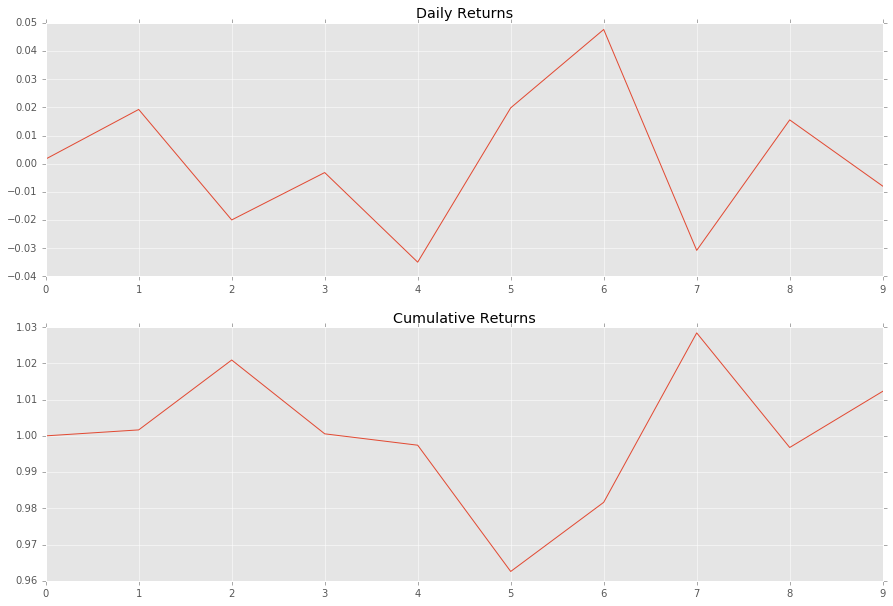

In [104]:
plt.figure(figsize = (15,10))

plt.subplot(211)
plt.plot(np.array(return_list)-1)
plt.title('Daily Returns')

plt.subplot(212)
r = np.array(return_list)
cum_returns = [np.prod(r[:i]) for i in range(len(return_list))]
plt.plot(cum_returns)
plt.title('Cumulative Returns')

In [98]:
# pure linear extraction
# use conner's non invest method
def lin_predict(X):
    return X[:,-1] / X[:,-2] - 1.

In [95]:
lin_predict(X)

(array([ 0.00935262,  0.        ,  0.0032127 , -0.00557621,  0.00098328,
         0.00036173,  0.        ,  0.        , -0.00019331, -0.00538987,
        -0.01530612, -0.01011545,  0.00324886,  0.        ,  0.01624257,
         0.0006514 ,  0.00260805, -0.01333338,  0.00512164,  0.00041992,
         0.        ,  0.00100278,  0.        ,  0.        , -0.0059083 ,
        -0.00518323, -0.08695652,  0.        , -0.03846154,  0.00235849,
        -0.06067693, -0.01958042, -0.00025288,  0.        , -0.00993178,
         0.00238949,  0.00332779, -0.00084311,  0.00162338, -0.00108108,
         0.01265823,  0.06420409, -0.01198047, -0.00199734, -0.07142857,
        -0.00871464,  0.        , -0.12669246,  0.00666667,  0.01737295]),
 None)